# Visualizations for Embeddings

In [ ]:
# Note: you may need to restart the kernel to use updated packages.
%pip install --upgrade whylogs[embeddings,viz]

In [2]:
import whylogs as why

why.__version__

'1.1.27'

In [74]:
import os
import pickle
from sklearn.datasets import fetch_openml

if os.path.exists("mnist_784_X_y.pkl"):
    X, y = pickle.load(open("mnist_784_X_y.pkl", 'rb'))
else:
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_prod, y_train, y_prod = train_test_split(X, y, test_size=0.1)

In [76]:
from whylogs.experimental.preprocess.embeddings.selectors import PCACentroidsSelector

references, labels = PCACentroidsSelector(n_components=20).calculate_references(X_train, y_train)

In [77]:
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
from whylogs.experimental.preprocess.embeddings.selectors import PCAKMeansSelector

unsup_references, unsup_labels = PCAKMeansSelector(n_clusters=8, n_components=20).calculate_references(X_train, y_train)

In [72]:
import whylogs as why
from whylogs.core.resolvers import MetricSpec, ResolverSpec
from whylogs.core.schema import DeclarativeSchema
from whylogs.experimental.extras.embedding_metric import (
    DistanceFunction,
    EmbeddingConfig,
    EmbeddingMetric,
)

config = EmbeddingConfig(
    references=references,
    labels=labels,
    distance_fn=DistanceFunction.euclidean,
)
schema = DeclarativeSchema([ResolverSpec(column_name="pixel_values", metrics=[MetricSpec(EmbeddingMetric, config)])])

train_profile = why.log(row={"pixel_values": X_train}, schema=schema)

In [6]:
train_profile_view = train_profile.view()
column = train_profile_view.get_column("pixel_values")
summary = column.to_summary_dict()
for digit in [str(i) for i in range(10)]:
    mean = summary[f'embedding/{digit}_distance:distribution/mean']
    stddev = summary[f'embedding/{digit}_distance:distribution/stddev']
    print(f"{digit} distance: mean {mean}   stddev {stddev}")

0 distance: mean 2190.2037281483754   stddev 202.0732007145136
1 distance: mean 2064.6653089212964   stddev 471.8772119543231
2 distance: mean 1994.465873387843   stddev 233.23772928564424
3 distance: mean 1997.9056142814343   stddev 273.7886368494953
4 distance: mean 1977.69744722824   stddev 304.7831110281608
5 distance: mean 1911.5998374892054   stddev 254.22613963848508
6 distance: mean 2027.1250663114222   stddev 258.67361746610055
7 distance: mean 2013.6681571924685   stddev 349.7098922494629
8 distance: mean 1937.0099723632827   stddev 262.4433198398257
9 distance: mean 1943.9855159685815   stddev 329.53459459216305


In [7]:
train_profile_view.to_pandas()

,embedding/0_distance:counts/inf,embedding/0_distance:counts/n,embedding/0_distance:counts/nan,embedding/0_distance:counts/null,embedding/0_distance:distribution/max,embedding/0_distance:distribution/mean,embedding/0_distance:distribution/median,embedding/0_distance:distribution/min,embedding/0_distance:distribution/n,embedding/0_distance:distribution/q_01,...,embedding/closest:counts/n,embedding/closest:counts/nan,embedding/closest:counts/null,embedding/closest:frequent_items/frequent_strings,embedding/closest:types/boolean,embedding/closest:types/fractional,embedding/closest:types/integral,embedding/closest:types/object,embedding/closest:types/string,type
column,,,,,,,,,,,,,,,,,,,,,
pixel_values,0,63000,0,0,3001.396682,2190.203728,2215.023167,1281.944781,63000,1531.231674,...,63000,0,0,"[FrequentItem(value='1', est=9270, upper=9270,...",0,0,0,0,63000,SummaryType.COLUMN


In [8]:
# Find which digits have more than or equal to 90% missing
not_empty_mask = (X_prod == 0).sum(axis=1) <= (0.9 * 784)
X_prod = X_prod[not_empty_mask]
y_prod = y_prod[not_empty_mask]

In [9]:
# Log production digits using the same schema
prod_profile_view = why.log(row={"pixel_values": X_prod}, schema=schema).profile().view()

In [10]:
train_profile_summary = train_profile_view.get_column("pixel_values").to_summary_dict()
prod_profile_summary = prod_profile_view.get_column("pixel_values").to_summary_dict()
for digit in [str(i) for i in range(10)]:
    mean_diff = train_profile_summary[f'embedding/{digit}_distance:distribution/mean'] - prod_profile_summary[f'embedding/{digit}_distance:distribution/mean']
    stddev_diff = train_profile_summary[f'embedding/{digit}_distance:distribution/stddev'] - prod_profile_summary[f'embedding/{digit}_distance:distribution/stddev']
    print(f"{digit} distance difference (target-prod): mean {mean_diff}   stddev {stddev_diff}")

0 distance difference (target-prod): mean 4.290036758599854   stddev -6.289313375068758
1 distance difference (target-prod): mean -48.6663367639253   stddev 44.80546039627558
2 distance difference (target-prod): mean -12.127708050731371   stddev -3.6053686197129764
3 distance difference (target-prod): mean -17.725786673383254   stddev -2.481124121829339
4 distance difference (target-prod): mean -9.032285863979268   stddev -5.092712093062119
5 distance difference (target-prod): mean -15.397205673310282   stddev 1.7124696466202636
6 distance difference (target-prod): mean -7.482575036404114   stddev -5.616297266111587
7 distance difference (target-prod): mean -14.996698404455856   stddev -0.8811321757631276
8 distance difference (target-prod): mean -15.069601061566345   stddev -6.970828000382255
9 distance difference (target-prod): mean -11.811082124419272   stddev -5.285637222610262


# Visualizations
Compare this to the raw data visualization. Note the locations of the labels matches the labels below.

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.decomposition import PCA

class ReferenceSelector:
    def __init__(self):
        self.n_references = 0
        self.ref_labels = None

    def calculate_references(self, X: np.array, y: np.array):
        raise NotImplementedError()

class EmbeddingsAnalysis:
    distance_fns = {'euclidean': euclidean_distances, 'cosine': cosine_distances}

    def __init__(self, X, y=None, 
                 distance='cosine'):
                 #reference_selector: ReferenceSelector = PCACentroids(n_components=2)):
        if distance not in EmbeddingsAnalysis.distance_fns:
            raise ValueError(f"Distance not valid. Choose one of {list(EmbeddingsAnalysis.distance_fns.keys())}.")
        self.X = X
        self.y = y
        self.labels = sorted(np.unique(y))
        self.distance_method = EmbeddingsAnalysis.distance_fns[distance]
        self.plot_pca = None
        self.X_plot_pca = None
        self.refs_plot_pca = None
        self.X_ref_dists = None
        self.X_ref_closest = None

        print("Calculating references...", end=" ")
        self.refs = references
        self.n_references = len(references)
        self.ref_labels = labels
        print("Done.")

        print("Calculating distances from data points to references...", end=" ")
        self.X_ref_dists = self.distance_method(self.X, self.refs)
        print("Done.")

        print("Finding closest reference for each data point...", end=" ")
        self.X_ref_closest = np.argmin(self.X_ref_dists, axis=1)
        print("Done.")

    def plot(self, X = None, y = None, n: int = 1000, show_references: bool = True, method: str = 'pca'):
        if self.X_plot_pca is None:
            print("Fitting PCA to data for plot for all data...", end=" ")
            # Fit PCA
            self.plot_pca = PCA(n_components=2)
            self.X_plot_pca = self.plot_pca.fit_transform(self.X)
            print("Done.")
        
        X_plot = self.X_plot_pca if X is None else self.plot_pca.transform(X)

        show_hue = True
        if X is None:
            y_plot = self.y
        elif y is not None:
            y_plot = y
        else:
            show_hue = False
            y_plot = np.zeros(len(X_plot))

        fig, ax = plt.subplots()
        
        if show_hue:
            sns.scatterplot(x=X_plot[:n, 0], y=X_plot[:n, 1], hue=y_plot[:n], s=20, ax=ax)
        else:
            sns.scatterplot(x=X_plot[:n, 0], y=X_plot[:n, 1], s=20, ax=ax)
        
        if show_references and self.refs is not None:
            if self.refs_plot_pca is None:
                self.refs_plot_pca = self.plot_pca.transform(self.refs)
            sns.scatterplot(x=self.refs_plot_pca[:, 0], y=self.refs_plot_pca[:, 1], color="black", marker="X", s=0, ax=ax)
            # centroid labels
            for i, ref_label in enumerate(self.ref_labels):
                plt.text(x=self.refs_plot_pca[i, 0], y=self.refs_plot_pca[i, 1], s=str(ref_label), horizontalalignment='center', 
                        color='black', weight='bold')
    
    def plot_3d_quiver(self):
        from matplotlib.colors import ListedColormap
        print("Fitting PCA to data for plot for all data...", end=" ")
        # Fit PCA
        plot_model = PCA(n_components=3)
        X_plot = plot_model.fit_transform(self.X)
        print("Done.")
        
        y_plot = self.y
        cmap = ListedColormap(["#f4843c", "#ffde1e", "#005566", "#44c3e3", "#2783c7"])

        
        ax = plt.axes(projection='3d')
        ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2], s=50, c=np.random.choice(["#f4843c", "#ffde1e", "#005566", "#44c3e3", "#2783c7"], X_plot.shape[0]))

        ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2], s=50, c=np.random.choice(["#f4843c", "#ffde1e", "#005566", "#44c3e3", "#2783c7"], X_plot.shape[0]))

        ax.set_xlim([-5,5])
        ax.set_ylim([-5,5])
        ax.set_zlim([-5,5])
        
        # centroid labels
        for ref_label, x, y, z in zip(word_list, X_plot[:, 0], X_plot[:, 1], X_plot[:, 2]):
            if ref_label in ["hyperparameter", "dataframe"]: continue
            if ref_label == "varianc": ref_label = "variance"
            ax.text(x, y, z, s="    "+ref_label, color='black', fontsize=6)

    def plot_reference_distances(self, X = None, n: int = 1000):
        X_plot = self.X_ref_dists if X is None else self.distance_method(X, self.refs)
        
        return sns.displot(data=pd.melt(pd.DataFrame(X_plot[:n]), var_name="Reference index", value_name="Distance"),
                               x="Distance", col="Reference index", col_wrap=2, kind='kde', height=1, aspect=3)

    def calc_closest_references_by_label(self, X = None, y = None, n: int = None):
        X_plot = self.X_ref_closest if X is None else np.argmin(self.distance_method(X, self.refs), axis=1)
        y_plot = self.y if X is None else y
        
        if n is None: 
            n = len(X_plot)
        
        closest_ref_count_by_label = []
        for label in self.labels:
            closest_ref_count_by_label.append(np.bincount(X_plot[:n][y_plot[:n]==label], 
                                                          minlength=self.n_references))
        closest_ref_count_by_label = np.array(closest_ref_count_by_label)
        return closest_ref_count_by_label

    def plot_closest_references_by_label(self, X = None, y = None, n: int = None):
        closest_ref_count_by_label = self.calc_closest_references_by_label(X, y, n)
        return sns.heatmap(closest_ref_count_by_label, annot=True, fmt=".0f", linewidth=1, linecolor='w').set(xlabel="Closest reference", ylabel="True label")
    
    def plot_closest_references(self, X = None, y = None, n: int = None):
        X_plot = self.X_ref_closest if X is None else np.argmin(self.distance_method(X, self.refs), axis=1)
        y_plot = self.y if X is None else y
        
        if n is None:
            n = len(X_plot)
        closest_ref_count = np.bincount(X_plot[:n], minlength=self.n_references)

        return sns.barplot(x=list(range(self.n_references)), y=closest_ref_count
                          ).set(xlabel="Reference index", ylabel="Closest count")

Calculating references... Done.
Calculating distances from data points to references... Done.
Finding closest reference for each data point... Done.
Fitting PCA to data for plot for all data... Done.


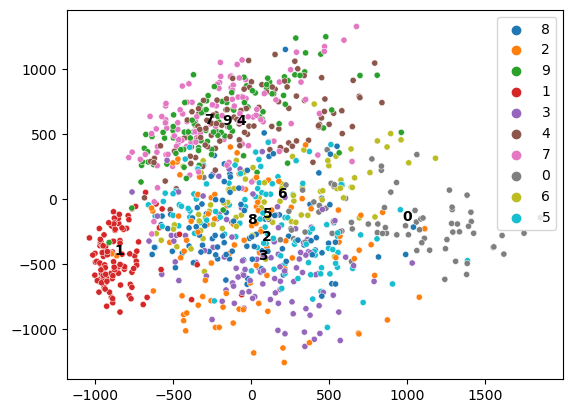

In [12]:
import seaborn as sns

b = EmbeddingsAnalysis(X_train, y_train, distance='cosine')
b.plot()

# Bubble Scatterplot
Without column labels, we will see a basic bubble scatterplot all the same color. (We could color it, but it will be confused with the next iteration.)

In [13]:
prod_profile_view.to_pandas()

,embedding/0_distance:counts/inf,embedding/0_distance:counts/n,embedding/0_distance:counts/nan,embedding/0_distance:counts/null,embedding/0_distance:distribution/max,embedding/0_distance:distribution/mean,embedding/0_distance:distribution/median,embedding/0_distance:distribution/min,embedding/0_distance:distribution/n,embedding/0_distance:distribution/q_01,...,embedding/closest:counts/n,embedding/closest:counts/nan,embedding/closest:counts/null,embedding/closest:frequent_items/frequent_strings,embedding/closest:types/boolean,embedding/closest:types/fractional,embedding/closest:types/integral,embedding/closest:types/object,embedding/closest:types/string,type
column,,,,,,,,,,,,,,,,,,,,,
pixel_values,0,6656,0,0,2958.26567,2185.913691,2211.939721,1307.050895,6656,1523.667472,...,6656,0,0,"[FrequentItem(value='3', est=722, upper=722, l...",0,0,0,0,6656,SummaryType.COLUMN


In [14]:
prod_profile_view.get_column(col_name="pixel_values").get_metric("embedding")

EmbeddingMetric(references=<whylogs.experimental.extras.matrix_component.MatrixComponent object at 0x7f9c17ac8df0>, labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], distance_fn=<function euclidean_distances at 0x7f9c1b237d30>, serialize_references=True)

In [15]:
# Dimensionality reduction for plotting
# This is a noteworthy aspect -- we should consider keeping the transformation model from the raw data.
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)

PCA(n_components=2)

<AxesSubplot:xlabel='x', ylabel='y'>

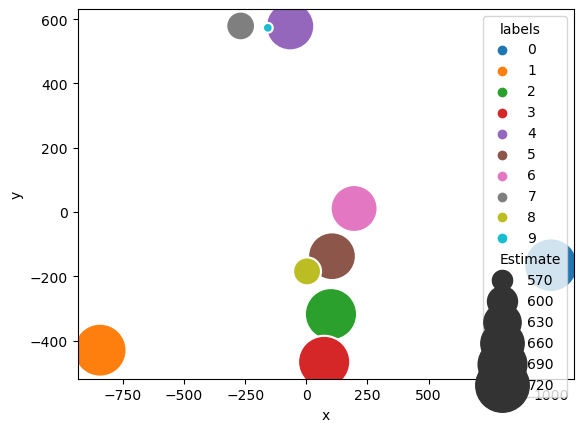

In [17]:

bubble_data = pd.DataFrame(prod_profile_view.get_column(col_name="pixel_values") \
              .get_metric("embedding").submetrics["closest"]["frequent_items"] \
              .frequent_strings.value.get_frequent_items(err_type=NO_FALSE_POSITIVES), \
                  columns=["Count", "LB", "Estimate", "UB"])
bubble_data["labels"] = labels

pca_refs = pca.transform(references)
bubble_data["x"] = pca_refs[:, 0]
bubble_data["y"] = pca_refs[:, 1]

# If we DON'T have reference data available, we'll see the bubbles one by one
sns.scatterplot(data=bubble_data, x="x", y="y", size="Estimate", hue="labels",
                legend=True, sizes=(50, 1500))

In [139]:
radius_values = []
for lbl in labels:
    radius_values.append(prod_profile_view.get_column(col_name="pixel_values").get_metric("embedding")\
          .submetrics[f"{lbl}_distance"]["distribution"].kll.value.get_quantiles([0.01])[0])

0 1000.2559843305957 -164.57649721887825 1523.6674721269674
1 -842.8481251583231 -428.4593463827617 987.6382655903733
2 99.8323249253443 -318.9460863609084 1559.674477293291
3 70.57455800176237 -463.6462359766196 1414.6668228539904
4 -68.10558741532292 576.6899499894804 1368.6102136208992
5 106.39521432626272 -137.42456541741842 1486.736954418472
6 193.12396259896812 10.144236301451254 1390.7566976475932
7 -266.4497511403378 578.5097288197509 1248.871540695403
8 3.5924188208705417 -184.23528088918164 1457.2426268665977
9 -157.00554777752345 573.7237532934352 1300.1754690087362


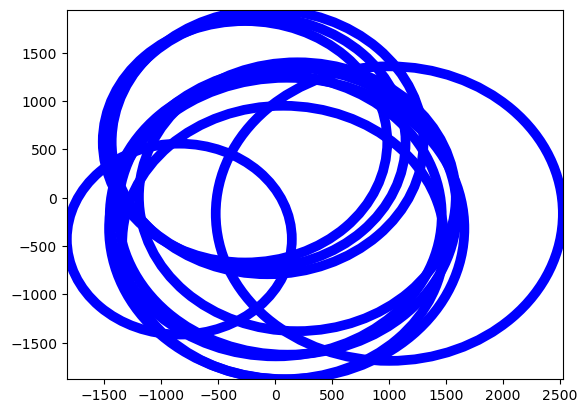

In [140]:
bubble_data = pd.DataFrame(radius_values, columns=["radius_values"])
bubble_data["labels"] = labels

pca_refs = pca.transform(references)
bubble_data["x"] = pca_refs[:, 0]
bubble_data["y"] = pca_refs[:, 1]

# If we DON'T have reference data available, we'll see the bubbles one by one
fig, ax = plt.subplots()
xlim = [np.inf,-np.inf]
ylim = [np.inf,-np.inf]
for row in bubble_data.iterrows():
    x = row[1]["x"]
    y = row[1]["y"]
    radius = row[1]["radius_values"]
    label = row[1]["labels"]
    print(label, x, y, radius)
    ax.add_patch(plt.Circle((x, y), radius, edgecolor="b", linewidth=7, fill=False))
    if x - radius < xlim[0]: xlim[0] = x - radius
    if x + radius > xlim[1]: xlim[1] = x + radius
    if y - radius < ylim[0]: ylim[0] = y - radius
    if y + radius > ylim[1]: ylim[1] = y + radius

plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

The above view raises some questions:
* Do we want to additionally track a better representative of the size/shape of each cluster?

# Heatmap with predictions (or actuals)

[Text(0.5, 23.52222222222222, 'Closest reference'),
 Text(50.722222222222214, 0.5, 'True label')]

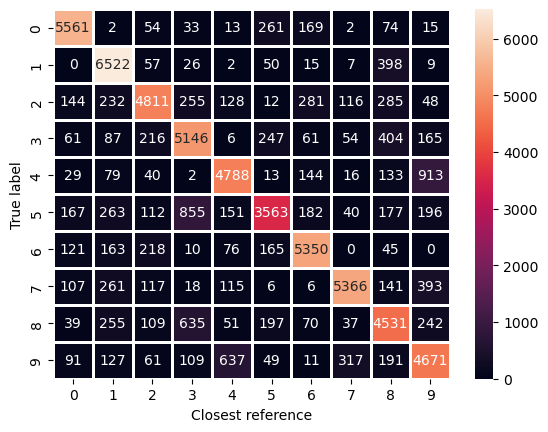

In [66]:
b.plot_closest_references_by_label()

# Circle packing Scatterplot

When we are able to multi-column, we'd like to pair the prediction with the embeddings. This is the most common analysis with this sort of chart.

In [20]:
bubble_data

,Count,LB,Estimate,UB,labels,x,y
0,3,722,722,722,0,1000.571535,-165.251253
1,9,717,717,717,1,-843.112977,-429.559778
2,4,712,712,712,2,100.893834,-317.527389
3,6,712,712,712,3,73.135841,-466.065509
4,7,688,688,688,4,-66.048099,577.900924
5,0,685,685,685,5,105.106282,-137.343912
6,1,680,680,680,6,195.601309,11.074862
7,2,596,596,596,7,-268.358069,578.886308
8,8,593,593,593,8,3.201129,-184.465095
9,5,551,551,551,9,-157.180648,573.032545


In [18]:
import circlify

In [60]:
(bubble_data.sort_values(by="Estimate", ascending=False)["Estimate"] * 5).tolist()

[3610, 3585, 3560, 3560, 3440, 3425, 3400, 2980, 2965, 2755]

[Circle(x=-0.772234810582928, y=-0.014676604888166416, r=0.22762573488813492, level=1, ex={'datum': 2755}), Circle(x=-0.5252758237236882, y=0.4551024501921103, r=0.23614182111624996, level=1, ex={'datum': 2965}), Circle(x=-0.5241405535865817, y=-0.4072110377015517, r=0.23673839087815923, level=1, ex={'datum': 2980}), Circle(x=-0.2933445378288352, y=0.02458882363345215, r=0.25287157750338635, level=1, ex={'datum': 3400}), Circle(x=-0.034258021898103334, y=-0.43256012657164045, r=0.2537995497136529, level=1, ex={'datum': 3425}), Circle(x=-0.03481455882934851, y=0.46098400536818745, r=0.25435470797752907, level=1, ex={'datum': 3440}), Circle(x=0.4782892576517624, y=0.4630074001048865, r=0.25875309805716906, level=1, ex={'datum': 3560}), Circle(x=0.4782892576517624, y=-0.4349059660616074, r=0.25875309805716906, level=1, ex={'datum': 3560}), Circle(x=0.21907874355519633, y=0.014050717021639531, r=0.2596600517599594, level=1, ex={'datum': 3585}), Circle(x=0.7393026439315489, y=0.014050717021

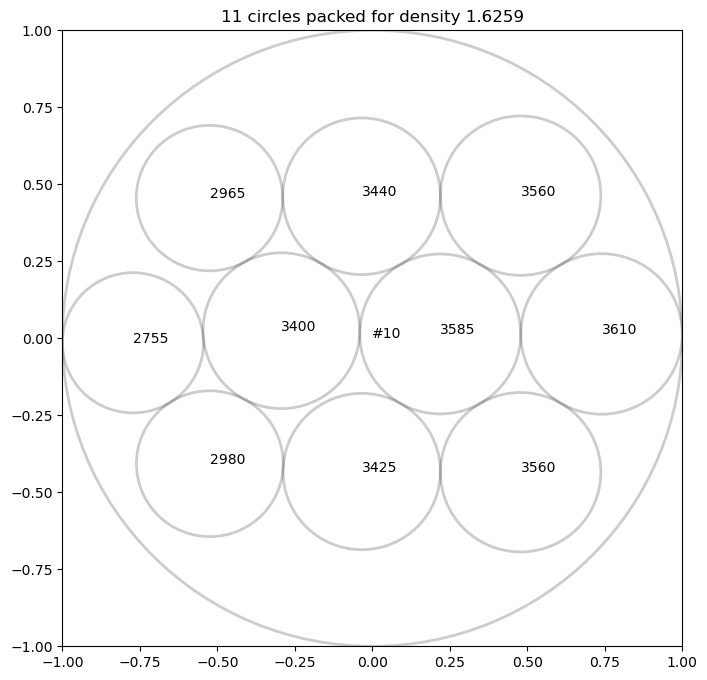

In [65]:
import circlify

circles = circlify.circlify(
    (bubble_data.sort_values(by="Estimate", ascending=False)["Estimate"] * 5).tolist(), 
    show_enclosure=True, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1))
print(circles)

labels = bubble_data.sort_values(by="Estimate", ascending=False)["labels"].tolist().append("")

circlify.bubbles(circles, labels=labels)

In [ ]:
for ref in pca_refs:
    print(ref)

In [ ]:
df = pd.DataFrame({"prediction": ["cat", "dog", "pig", "cat"], 
                   "first_actual": ["cat", "horse", "cow", "pig"],
                   "second_actual": ["pig", "donkey", "pig", "dolphin"],
                   "third_actual": ["elephant", "robin", "giraffe", "elephant"]})

In [ ]:
import pandas as pd
import whylogs as why
from whylogs.api.writer.whylabs import WhyLabsWriter


df = pd.DataFrame({"raw_predictions": ["cat", "dog", "pig", "cat"],
                   "raw_targets": [["cat", "pig", "elephant"], ["horse", "donkey", "robin"],
                                   ["cow", "pig", "giraffe"], ["pig", "dolphin", "elephant"]]})

def top_k_to_binary_predictions(k: int, 
                                data: pd.DataFrame, 
                                prediction_col_name: str, 
                                target_col_name: str):
    data["converted_predictions"] = data[prediction_col_name]
    data["converted_targets"] = data.apply(
        lambda row: row[prediction_col_name] if row[prediction_col_name] in row[target_col_name][:k] else f"Not in top-{k}", 
        axis=1
    )
    return data[["converted_predictions", "converted_targets"]]

converted_df = top_k_to_binary_predictions(k=2, 
                                           data=df, 
                                           prediction_col_name="raw_predictions", 
                                           target_col_name="raw_targets")

results = why.log_classification_metrics(converted_df, 
                                         target_column="converted_targets",
                                         prediction_column="converted_predictions",
                                         score_column=None, # Pass in confidence scores or thresholds if available
                                         log_full_data=True # Change to False if you've already logged the input data
)

results.writer("whylabs").write()

In [ ]:
df["combined_actuals"] = df.apply(lambda row: [row["first_actual"], row["second_actual"], row["third_actual"]], axis=1)

In [ ]:
def top_k_to_binary_predictions(k: int, data: pd.DataFrame, prediction_col_name: str, actuals_col_name: str):
    data["converted_actuals"] = data.apply(lambda row: row[prediction_col_name] if row[prediction_col_name] in row[actuals_col_name][:k] else f"Not in top-{k}", axis=1)
    return data[[prediction_col_name, "converted_actuals"]]

In [ ]:
top_k_to_binary_predictions(k=2, data=df, prediction_col_name="prediction", actuals_col_name="combined_actuals")

In [ ]:
df